# MonReader

This project develops a machine learning model for classification tasks in the field of computer vision. In the notebook, a three-layer CNN model is trained on the low-resolution images of a book from the mobile. The trained model extracts the relevant features and patterns from the low-resolution image and classifies them as 'flip' and 'not flip'.

Let's start with a small description of the relevance of this project to an industrial application. MonReader is a new mobile document digitization experience for the blind, researchers, and everyone else needing fully automatic, high-speed, and high-quality document scanning in bulk. It is composed of a mobile app and all the user needs to do is flip pages MonReader handles everything: it detects page flips from a low-resolution camera preview and takes a high-resolution picture of the document, recognizing its corners and crops it accordingly, and it dewarps the cropped document to obtain a bird's eye view, sharpens the contrast between the text and the background and finally recognizes the text with formatting kept intact, being further corrected by MonReader's ML powered redactor.

Here, I am focusing on the first step of the MonReader process, i.e. detecting a page flip from low-resolution images, which triggers subsequent steps from capturing high-resolution images to reading text. The contents of this notebook are as follows:
- 1. Extract Images
- 2. Data Preprocessing
- 3. Convolutional Neural Network
    - 3.1 Model Development
    - 3.2 Model Training 
- 4. Results
    - 4.1 Convergence of Accuracy and Loss function
    - 4.2 Confusion Matrix
    - 4.3 Gradient-weighted Class Activation Mapping (Grad-CAM)
- 5. Discussion

## 1. Extract Images

In this section, I have created a function `get_data`, which looks extract all the images inside a directory. The images files of available data set has following structure:
- images
    - testing
        - flip
        - notflip
    - training
        - flip
        - notflip

Import the necessary libraries to change directories, read data, and plot results.

In [1]:
import os
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt

The `get_data` function read images file using `cv2.imread` function, convert it RGB format, and reshape images to required size. 

In [2]:
labels = ['flip', 'notflip']
img_size = 224
def get_data(data_dir):
    data_x, data_y = [] , []
    for label in labels: 
        path = os.path.join(data_dir, label)
        lst_files = sorted(os.listdir(path))
        for img in lst_files:
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data_x.append(resized_arr)
                data_y.append(labels.index(label))
            except Exception as e:
                print(e)
    return np.array(data_x), np.array(data_y)

The images inside training and testing directories are read separately and store in 'train' and 'test' variables, respectively.

In [3]:
x_train, y_train = get_data(os.path.join(os.getcwd(), 'images/training'))
x_test, y_test = get_data(os.path.join(os.getcwd(), 'images/testing'))

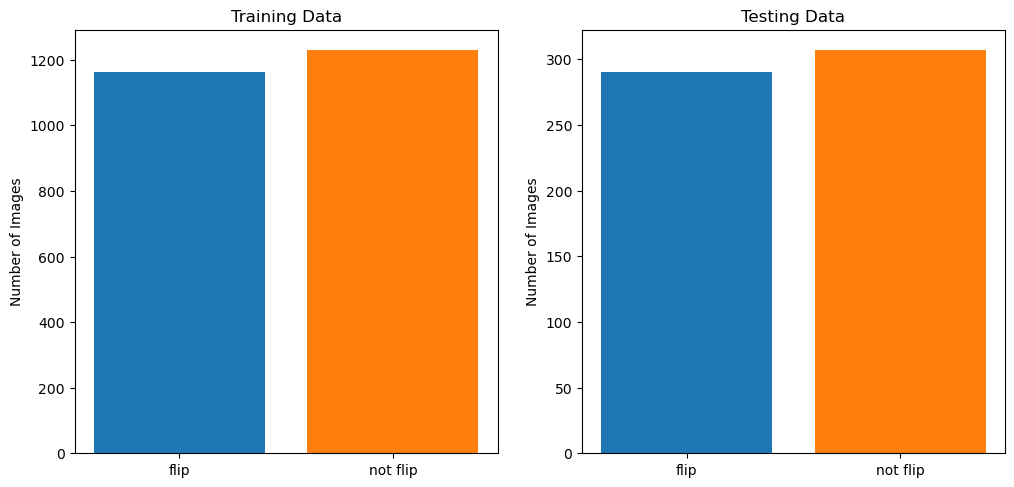

In [4]:
train_count1, test_count1 = sum(y_train), sum(y_test)
train_count0, test_count0 = len(y_train) - train_count1, len(y_test) - test_count1

fig, axes = plt.subplots(1, 2, figsize=(12, 5.5))
axes[0].bar(['flip', 'not flip'], [train_count0, train_count1], color=['C0', 'C1'])
axes[0].set_ylabel('Number of Images')
axes[0].set_title('Training Data')
axes[1].bar(['flip', 'not flip'], [test_count0, test_count1], color=['C0', 'C1'])
axes[1].set_ylabel('Number of Images')
axes[1].set_title('Testing Data')
plt.show()

In [5]:
print('Total number of images in training set: {}'.format(train_count0+train_count1))
print('Total number of images in training set: {}'.format(test_count0+test_count1))
print('The train to test ratio is {:1.2f}'.format((train_count0+train_count1)/(test_count0+test_count1)))

Total number of images in training set: 2392
Total number of images in training set: 597
The train to test ratio is 4.01


The plot shows that there are no imbalances in the data set and techniques such as SMOTE (Synthetic Minority Sampling Technique) and Balanced Bagged Classifier are not required for this problem.

Here, is an example of images in the data set. The images are not clear due to low resolution, thus these can't be used to read the text but the main idea is to detect the page-flipping and then capture high-resolution images.

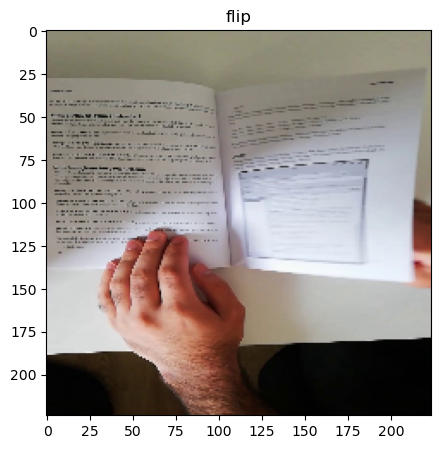

In [6]:
plt.figure(figsize = (5,5))
plt.imshow(x_train[1, :, :, :])
plt.title(labels[y_train[1]])
plt.show()

## 2. Data Preprocessing

The next steps is to preprocess the data such that it can help improve the performanc of the CNN model. This section implements two methods normalization, which scale input features and improve learning rate during model training.

### 2.1 Normalization

Normalize the input data to project picture pixels to a range between 0 to 1. This results in similar data distribution, which allows for faster convergence while the network is being trained. Our original images consist of RGB coefficients in the 0-255, but such values would be too high for our models to process (given a typical learning rate), so we target values between 0 and 1 instead by scaling with a 1/255 factor.

In [7]:
x_train.reshape(-1, img_size, img_size, 1)
x_train = x_train/255


x_test.reshape(-1, img_size, img_size, 1)
x_test = x_test/255

## 3. Convolution Neural Network 

Here, we will use Tensorflow for the implementation of CNN model.

Import the necessary library.

In [8]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

### 3.1 Model Development

Define a CNN model with three layers of alternate convolution and max-pooling layer. A dropout and two dense layers are added after the 3rd max pool operation to avoid overfitting.

- The max pool layer downscales the image and extracts the most important features, it helps the model to become invariant to the location and orientation of them.
- Dropout layers help decorrelate the weights, it prevents all weights from synchronously optimizing their weights.
- The Dense layers at the end help capture fine-grained details in the images.

In [9]:
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(224,224,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(2, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0

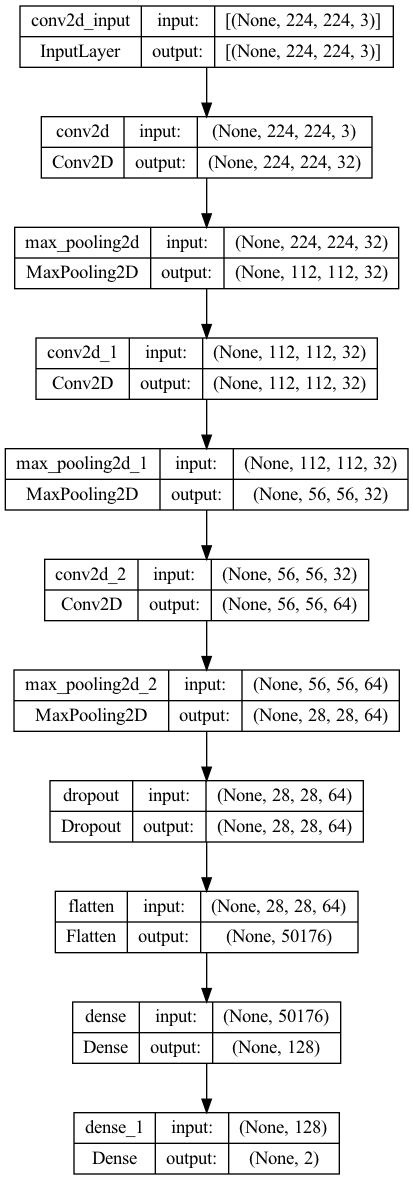

In [10]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='figures/model_plot.png', show_shapes=True, show_layer_names=True)

### 3.2 Model training

Trained the model using adam optimization algorithm and categorical cross entropy loss function for 100 epochs. 

In [11]:
optimizer = Adam()
model.compile(optimizer=optimizer , loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics=['accuracy'])

In [12]:
start_time = time.time()
history = model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test))
print('Time to train the model is {:.2f} seconds'.format(time.time()-start_time))

Epoch 1/100


2024-01-21 20:11:11.388580: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


75/75 [==============================] - 30s 385ms/step - loss: 0.7026 - accuracy: 0.5815 - val_loss: 0.5951 - val_accuracy: 0.6918
Epoch 2/100
75/75 [==============================] - 30s 406ms/step - loss: 0.3963 - accuracy: 0.8211 - val_loss: 0.2891 - val_accuracy: 0.9028
Epoch 3/100
75/75 [==============================] - 29s 387ms/step - loss: 0.2341 - accuracy: 0.9038 - val_loss: 0.2275 - val_accuracy: 0.9296
Epoch 4/100
75/75 [==============================] - 29s 388ms/step - loss: 0.1401 - accuracy: 0.9486 - val_loss: 0.1531 - val_accuracy: 0.9414
Epoch 5/100
75/75 [==============================] - 28s 367ms/step - loss: 0.0944 - accuracy: 0.9670 - val_loss: 0.1133 - val_accuracy: 0.9598
Epoch 6/100
75/75 [==============================] - 28s 374ms/step - loss: 0.0644 - accuracy: 0.9778 - val_loss: 0.0338 - val_accuracy: 0.9883
Epoch 7/100
75/75 [==============================] - 28s 367ms/step - loss: 0.0657 - accuracy: 0.9774 - val_loss: 0.0736 - val_accuracy: 0.9816
Epoc

19/19 [==============================] - 2s 95ms/step


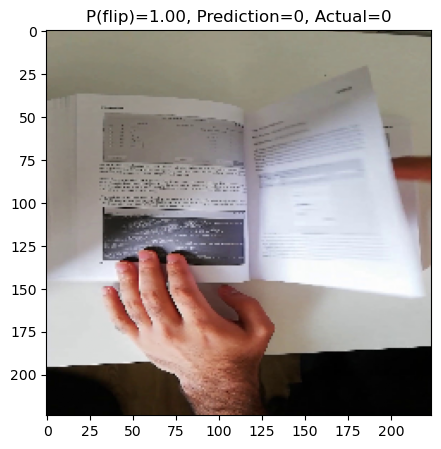

In [13]:
plt.figure(figsize = (5,5))
plt.imshow(x_test[1, :, :, :])
prob = model.predict(x_test)
tmp_pred = [0 if prob[1][0] > prob[1][1] else 1]
plt.title('P(flip)={:1.2f}, Prediction={}, Actual={}'.format(prob[1][0], tmp_pred[0], y_test[1]))
plt.show()

## 4. Results

This section illustrate the convergence of accuracy and loss function of the model for training and testing data. 

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [15]:
print('Accuracy of CNN model on Training data: {:.3f}%'.format(acc[-1]*100))
print('Accuracy of CNN model on Testng data: {:.3f}%'.format(val_acc[-1]*100))

Accuracy of CNN model on Training data: 100.000%
Accuracy of CNN model on Testng data: 99.665%


### 4.1 Convergence of Accuracy and Loss function

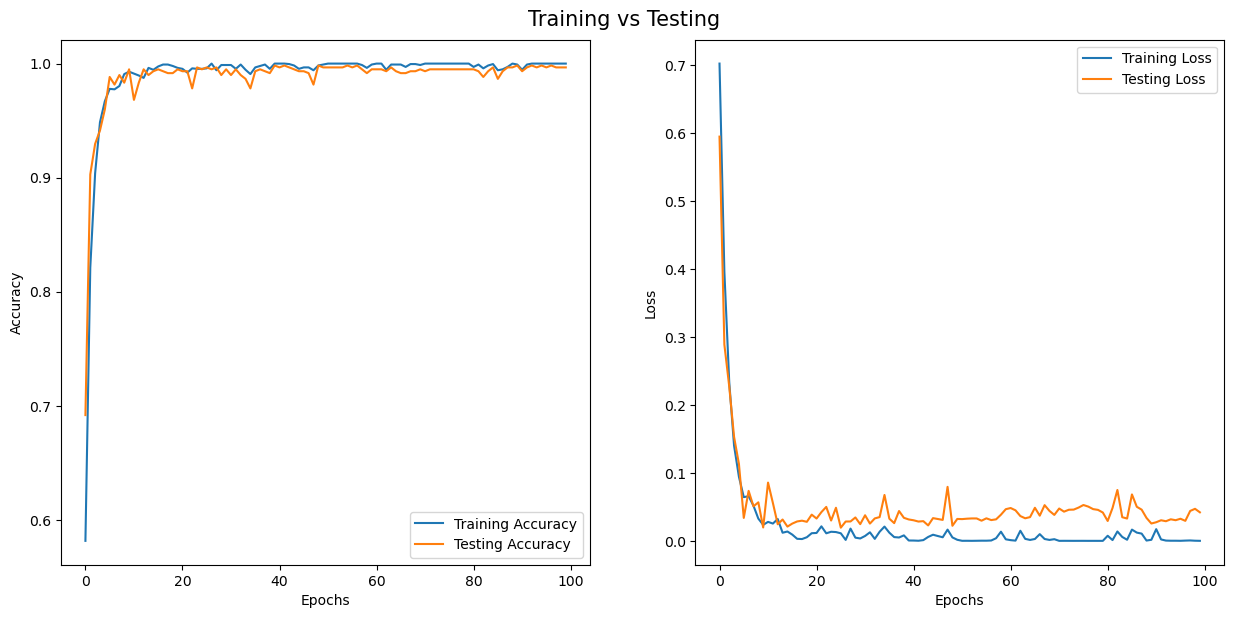

In [16]:
epochs_range = range(100)

plt.figure(figsize=(15, 15))
plt.suptitle('Training vs Testing', y=0.9, fontsize=15)
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Testing Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Testing Loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('figures/convergence_accuracy_loss.png', dpi=300)
plt.show()

### 4.2 Confusion Matrix

Lets compute the Confusion matrix using functions provided by the `sklearn` library.

In [17]:
from sklearn.metrics import confusion_matrix

In [18]:
preds = [0 if x[0]>x[1] else 1 for x in prob]

conf_matrix = confusion_matrix(y_test, preds)

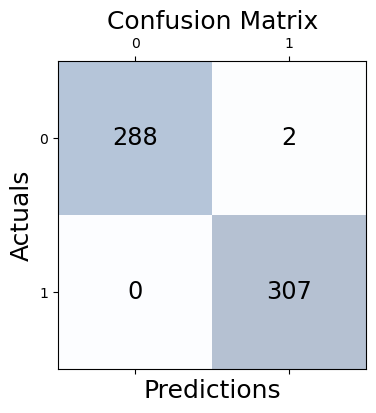

In [19]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.savefig('figures/confusion_matrix.png', dpi=300)
plt.show()

### 4.3 Gradient-weighted Class Activation Mapping (Grad-CAM)

Grad-CAM uses the output of the final convolutional layer in the network and examines the gradient information flowing into the final layer.

The `compute_grad_cam` function defined below, returns a heatmap visualization for the 'page flip' class label (i.e. 0). We can use this heatmap to visually verify where in the image the CNN is looking.

In [20]:
def compute_grad_cam(model_, img_array, layer_name='conv2d_2'):
    """
    This function computes the Gradient-weighted Class Activation Mapping and returns a heatmap.
    """
    eps=1e-8
    img_array = img_array.reshape(tf.expand_dims(img_array, axis=0).shape.as_list())
    gradModel = keras.models.Model(inputs=[model_.inputs],
                                   outputs=[model_.get_layer(layer_name).output, model_.output])
    # Forward propagate the image through the gradient model and compute the loss
    with tf.GradientTape() as tape:
       inputs = tf.cast(img_array, tf.float32)
       (convOutputs, predictions) = gradModel(inputs)
       loss = predictions[:, 0]
    # Use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)
    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
    # the convolution and guided gradients have a batch dimension (which we don't need) 
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    # compute the average of the gradient values, and use them as weights, 
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    # compute the ponderation of the filters concerning the weights
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
    # grab the spatial dimensions of the input image
    (w, h) = (img_array.shape[2], img_array.shape[1])
    # resize the output class activation map to match the input image dimensions
    heatmap = cv2.resize(cam.numpy(), (w, h))
    # normalize the heatmap such that all values lie in the range [0, 1]
    numerator = heatmap - np.min(heatmap)
    denominator = (heatmap.max() - heatmap.min()) + eps
    heatmap = numerator/denominator
    return heatmap

Let's focus on the images that are misclassified by the model. There is one false positive case (flipping page image, predicted as not flipping) and two false negative cases (not flipping page images, predicted as flipping). Let's first look at the false positive case.

In [21]:
# Index of images in test dataset with incorrect model prediction.
np.where(y_test != preds)[0]

array([145, 146])

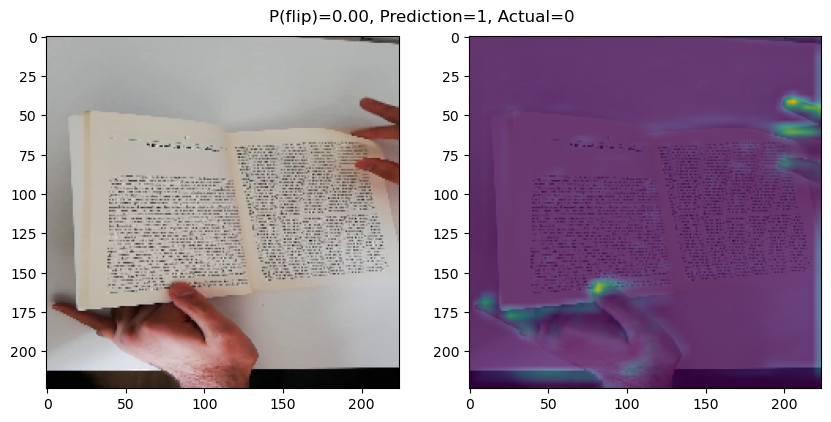

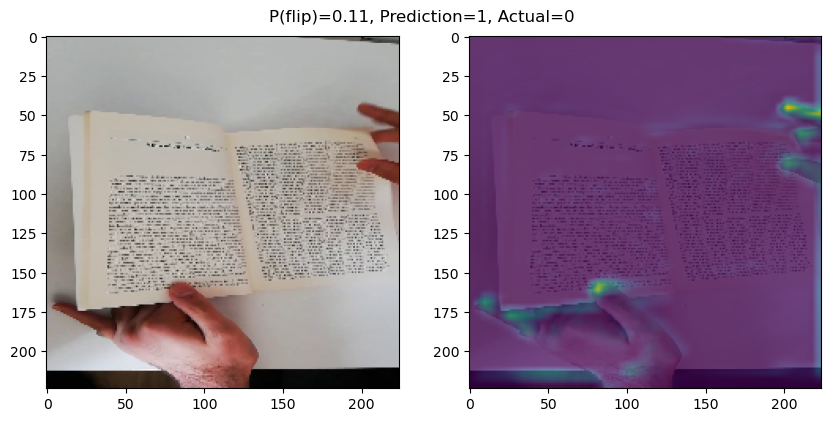

In [22]:
for i in np.where(y_test != preds)[0]:
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    ax[0].imshow(x_test[i, :, :, :])
    tmp_pred = [0 if prob[i][0]>prob[i][1] else 1]

    heatmap = compute_grad_cam(model, x_test[i, :, :, :], layer_name='conv2d_2')
    ax[1].imshow(x_test[i, :, :, :])
    ax[1].imshow(heatmap, alpha=0.7)
    
    fig.suptitle('P(flip)={:1.2f}, Prediction={}, Actual={}'.format(prob[i][0], tmp_pred[0], y_test[i]), y=0.9)
    plt.savefig('figures/misclassification_{}.png'.format(i), dpi=300)
    plt.show()

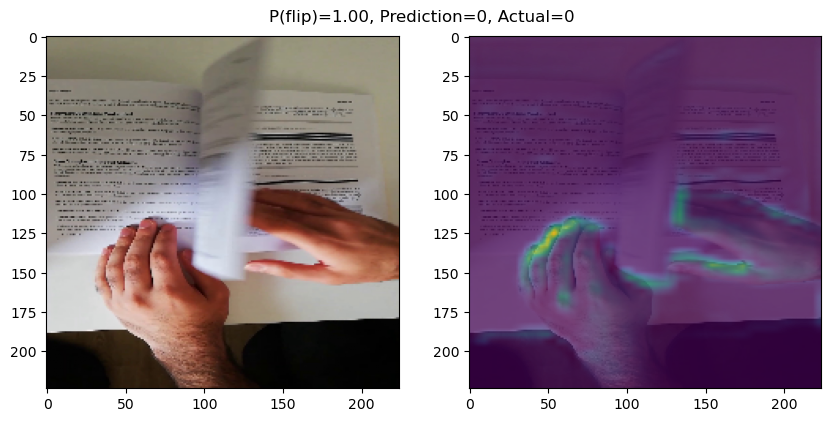

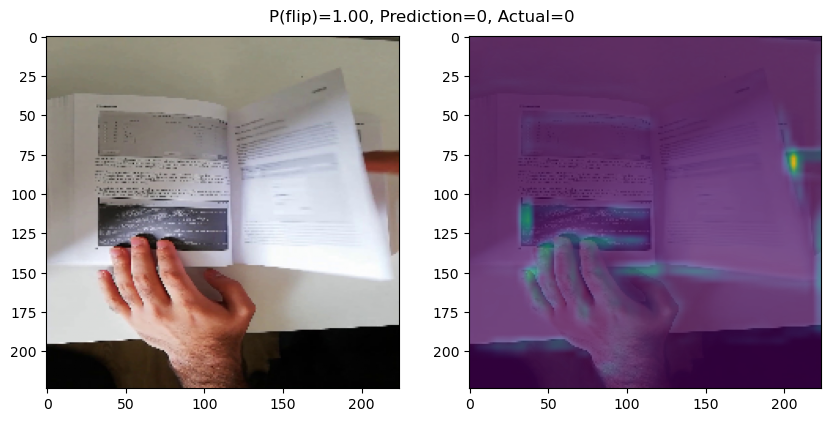

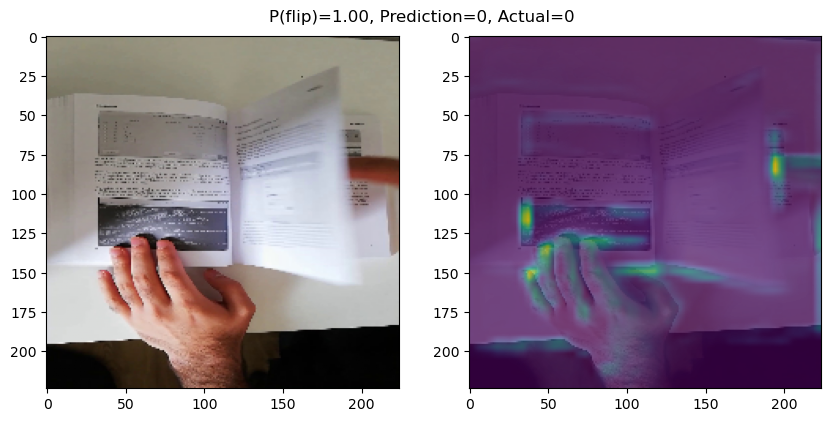

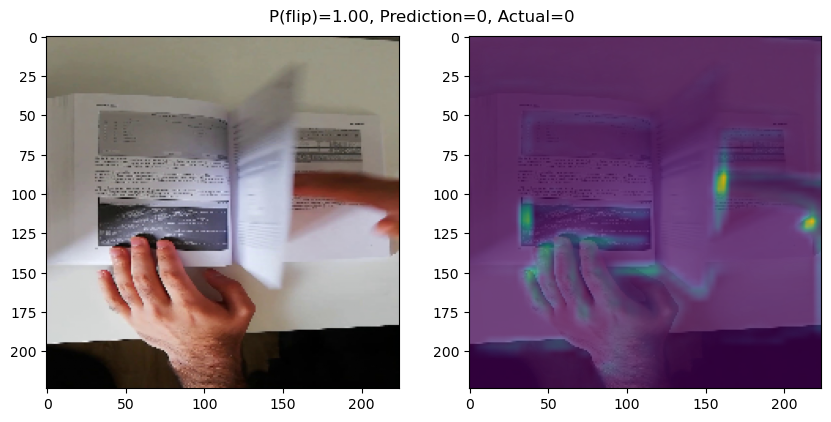

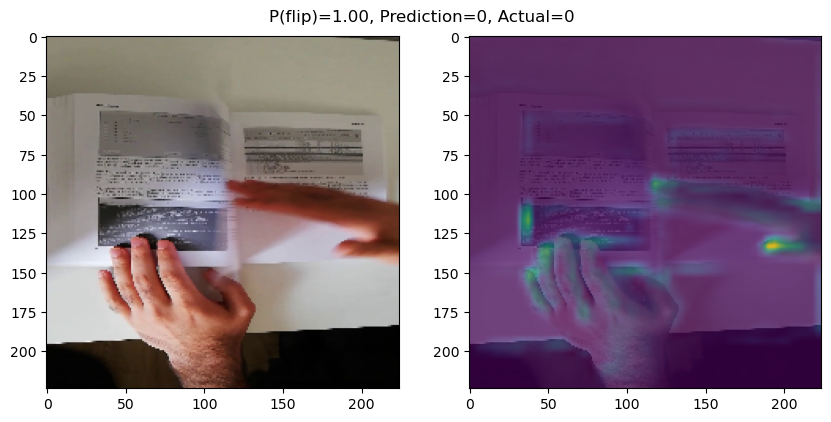

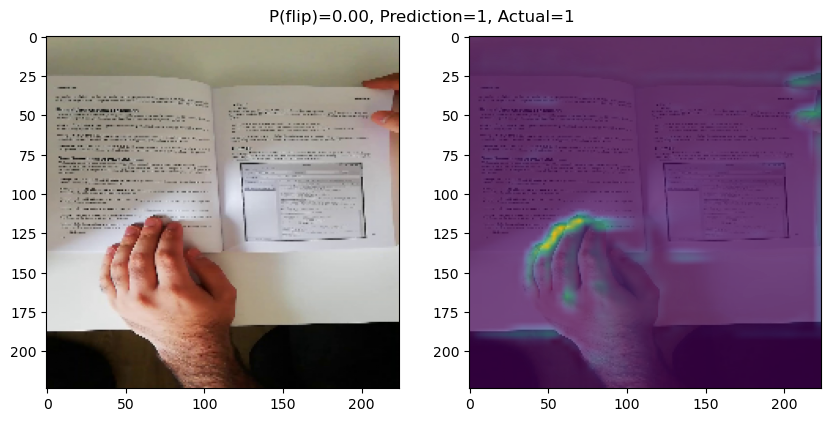

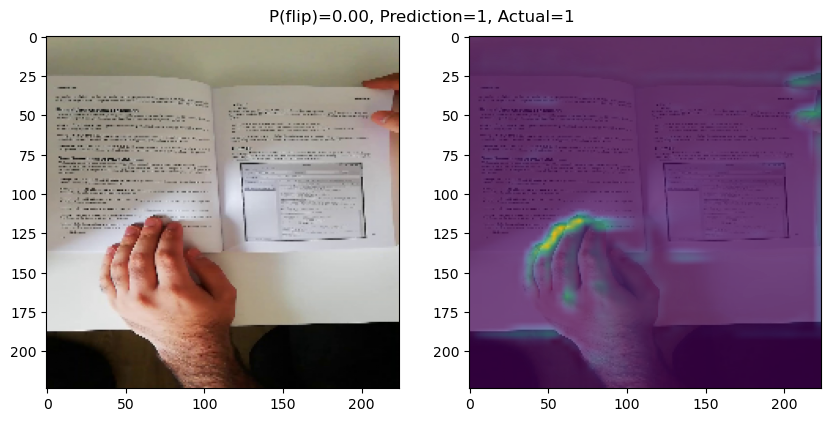

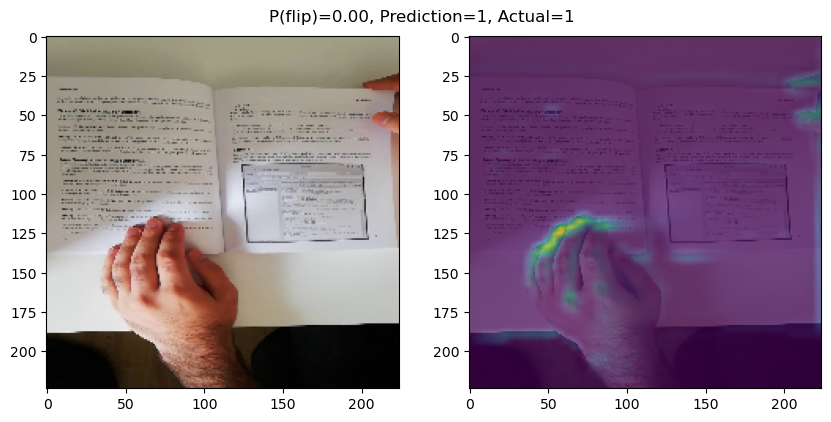

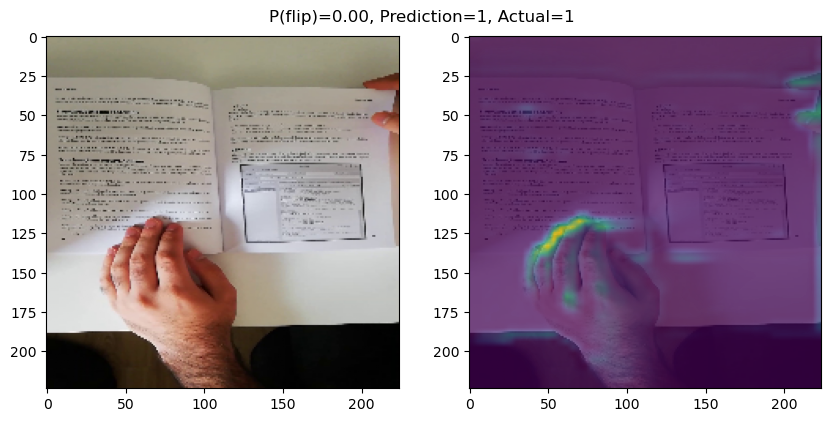

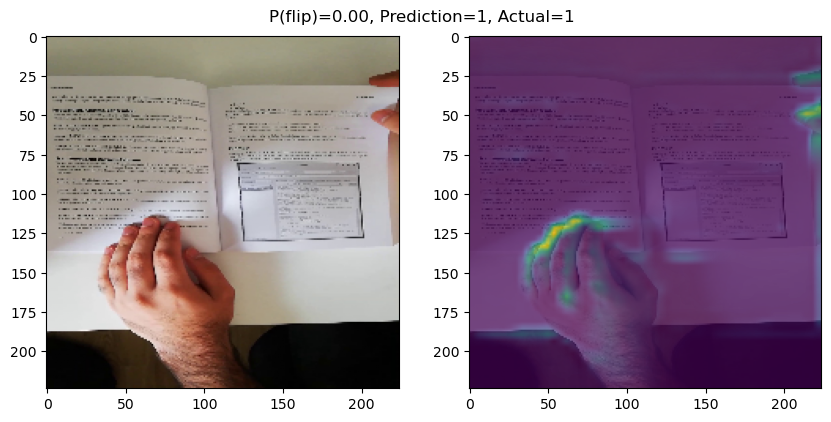

In [23]:
number_of_images = 5
counter = {0: number_of_images, 1: number_of_images}
for i in np.where(y_test == preds)[0]:
    if counter[0] == 0 and counter[1] == 0:
        break
    elif counter[y_test[i]] == 0:
        continue
    counter[y_test[i]] -= 1
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    ax[0].imshow(x_test[i, :, :, :])
    tmp_pred = [0 if prob[i][0]>prob[i][1] else 1]

    heatmap = compute_grad_cam(model, x_test[i, :, :, :], layer_name='conv2d_2')
    ax[1].imshow(x_test[i, :, :, :])
    ax[1].imshow(heatmap, alpha=0.7)
    
    fig.suptitle('P(flip)={:1.2f}, Prediction={}, Actual={}'.format(prob[i][0], tmp_pred[0], y_test[i]), y=0.9)
    plt.show()

## 5. Discussion

In this notebook, I have implemented a 3-layer CNN model using TensorFlow to identify the "page flipping" action using low-resolution images from mobile. The ratio of images in the training and test data set is 4:1. The CNN model is trained on 2392 images to optimize 6,451,554 weights in the model, which took approximately 1 hour. 